In [7]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def _load_csv(path):
    if not path.exists():
        raise FileNotFoundError(str(path))
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, on_bad_lines="skip")

def _pick_x_and_label(df):
    for cand in ['Time', 'time', 'Timestamp', 'timestamp', 'TSC', 'ts', 'Sample', 'sample', 'Step', 'step', 'Iter', 'iter']:
        if cand in df.columns:
            return df[cand], cand
    return pd.Series(range(len(df))), 'Sample'

def _match_col(df, want):
    for c in df.columns:
        cn = c.strip().lower().replace(" ", "")
        if want == "IPS":
            if cn == "ips" or "instructionspersecond" in cn:
                return c
        elif want == "Memory Throughput (MB/S)":
            r = cn.replace("/", "")
            if "memorythroughput" in r or "memthroughput" in r or "mb/s" in c.lower():
                return c
        elif want == "LLC Misses":
            if cn in ("llcmisses","llc-misses","llcmiss") or ("llc" in cn and "miss" in cn):
                return c
        elif want == "Package Power (W)":
            if cn in ("packagepower(w)", "packagepower", "pkg_power", "package"):
                return c
    if want == "Package Power (W)":
        for c in df.columns:
            low = c.lower()
            if "power" in low and "dram" not in low:
                return c
    raise KeyError(f"Could not find column for {want}. Available: {list(df.columns)}")

def collect_data(base_dir, apps=None):
    if apps is None:
        apps = benchmarks
    out = {}
    errs = {}
    base = Path(base_dir).expanduser().resolve()

    for app in apps:
        app_dir = base / app
       
        if not app_dir.is_dir():
            errs[app] = f"not a directory: {app_dir}"
            continue
        metrics_path = app_dir / "cpu_metrics.csv"
        power_path = app_dir / "cpu_power.csv"
        mdf = _load_csv(metrics_path)
        pdf = _load_csv(power_path)

        # Always prefer Time (s) if available
        if "Time (s)" in mdf.columns:
            x_m = mdf["Time (s)"]
            xlab_m = "Time (s)"
        else:
            x_m, xlab_m = _pick_x_and_label(mdf)

        if "Time (s)" in pdf.columns:
            x_p = pdf["Time (s)"]
            xlab_p = "Time (s)"
        else:
            x_p, xlab_p = _pick_x_and_label(pdf)

        ips_col = _match_col(mdf, "IPS")
        mem_col = _match_col(mdf, "Memory Throughput (MB/S)")
        llc_col = _match_col(mdf, "LLC Misses")
        pwr_col = _match_col(pdf, "Package Power (W)")

        out[app] = {
            "metrics": {
                "x": x_m,
                "x_label": xlab_m,
                "IPS": mdf[ips_col],
                "Memory Throughput (MB/S)": mdf[mem_col],
                "LLC Misses": mdf[llc_col],
            },
            "power": {
                "x": x_p,
                "x_label": xlab_p,
                "Package Power (W)": pdf[pwr_col],
            }
        }
    return out


def plot_app(app, data, save_dir=None):
    d = data[app]
    x_m, xlab_m = d["metrics"]["x"], d["metrics"]["x_label"]
    x_p, xlab_p = d["power"]["x"], d["power"]["x_label"]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    # IPS
    axes[0].plot(x_m, d["metrics"]["IPS"])
    axes[0].set_xlabel(xlab_m)
    axes[0].set_ylabel("IPS")
    axes[0].set_title("IPS")
    axes[0].grid(True)

    # Memory Throughput
    axes[1].plot(x_m, d["metrics"]["Memory Throughput (MB/S)"])
    axes[1].set_xlabel(xlab_m)
    axes[1].set_ylabel("MB/s")
    axes[1].set_title("Memory Throughput")
    axes[1].grid(True)

    # LLC Misses
    axes[2].plot(x_m, d["metrics"]["LLC Misses"])
    axes[2].set_xlabel(xlab_m)
    axes[2].set_ylabel("Misses")
    axes[2].set_title("LLC Misses")
    axes[2].grid(True)

    # Package Power
    axes[3].plot(x_p, d["power"]["Package Power (W)"])
    axes[3].set_xlabel(xlab_p)
    axes[3].set_ylabel("Watt")
    axes[3].set_title("Package Power")
    axes[3].grid(True)

    fig.suptitle(app)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(Path(save_dir) / f"{app}_all_metrics.png", dpi=150)

    plt.show()



def plot_all(data, save_dir=None, apps=None):
    if apps is None:
        apps = list(data.keys())
        for app in apps:
            plot_app(app, data, save_dir=save_dir)
      


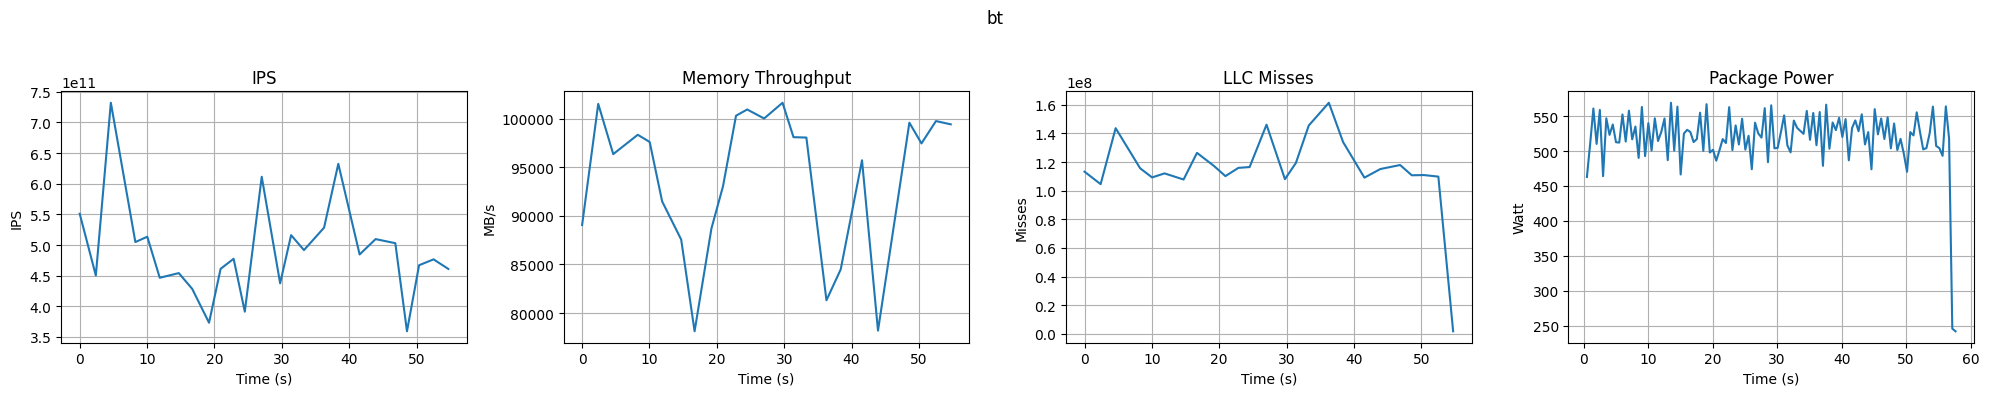

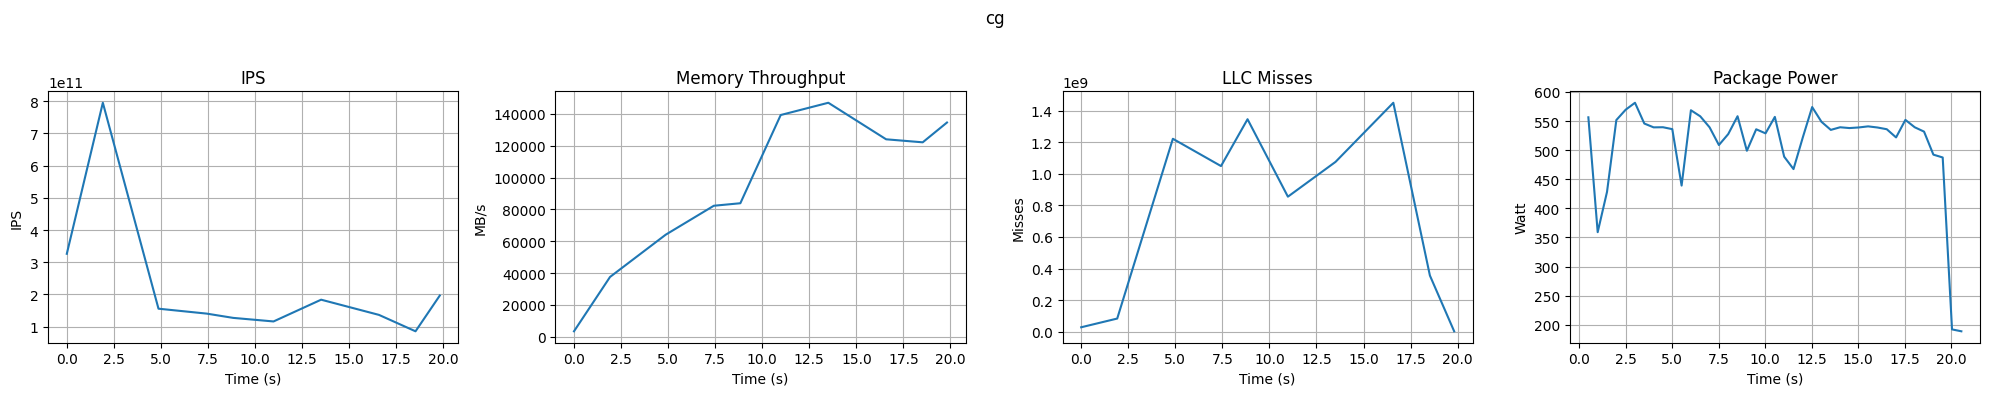

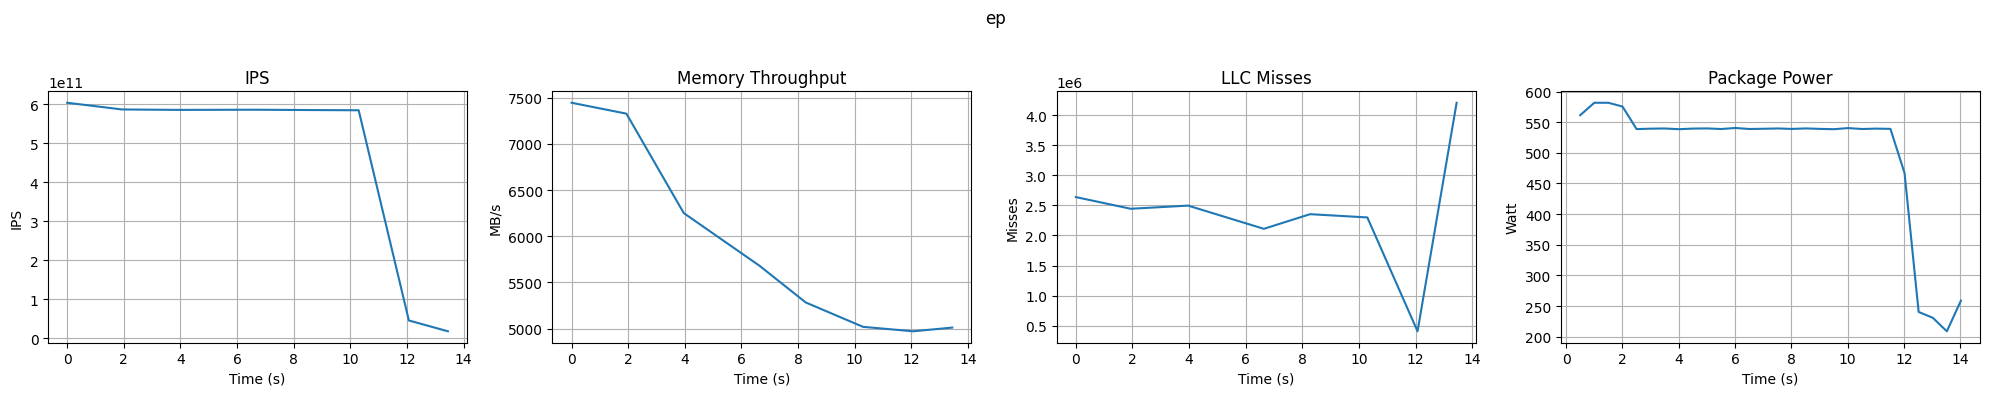

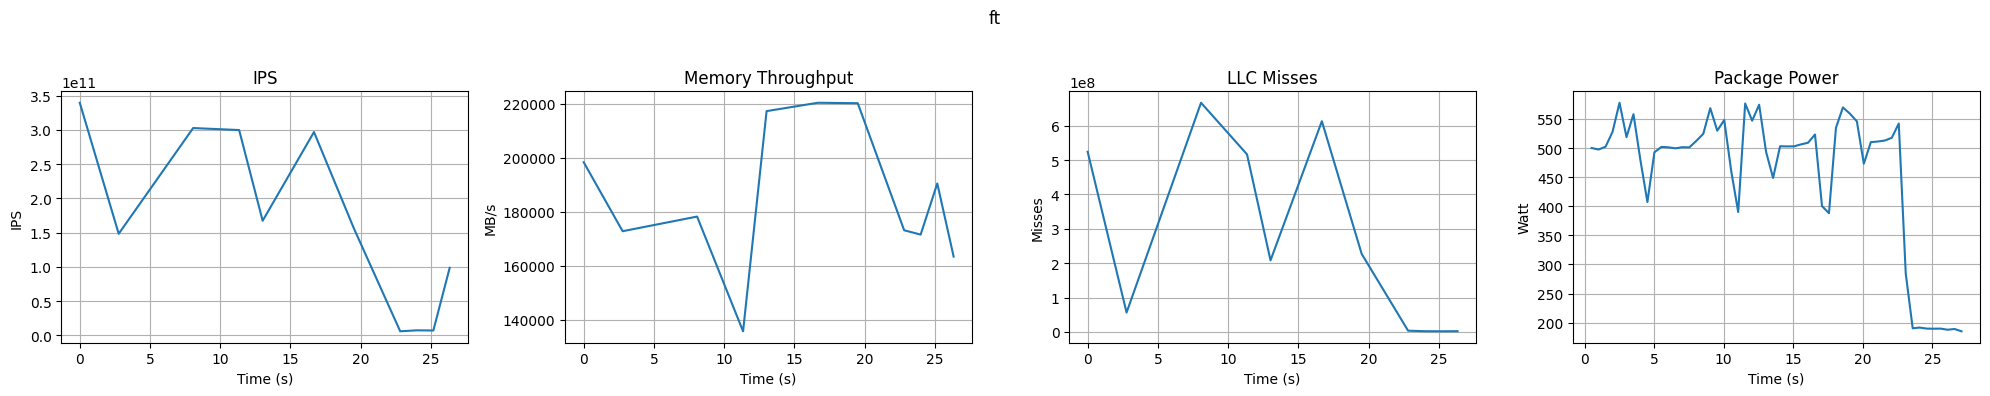

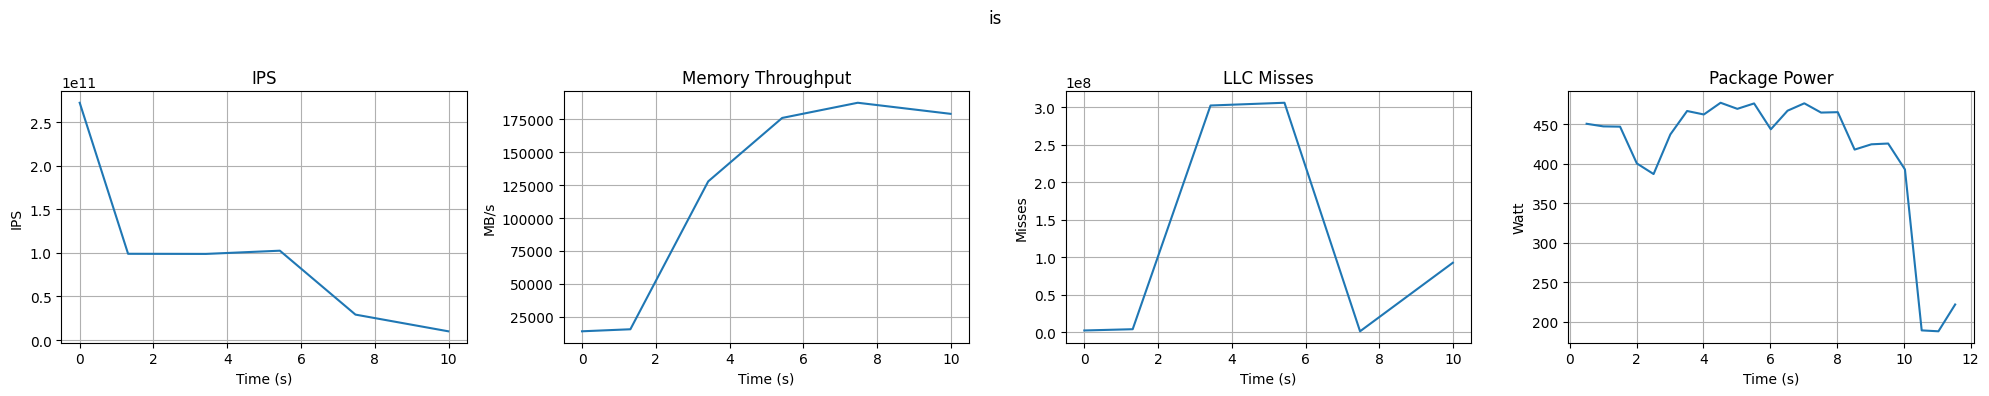

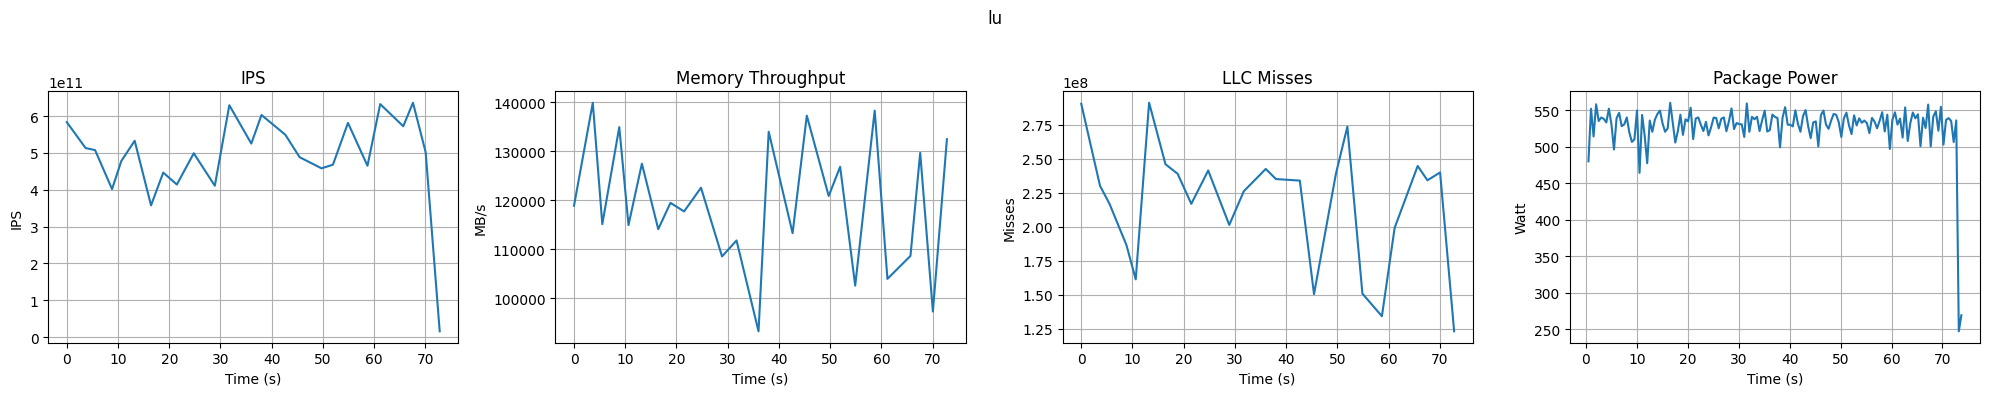

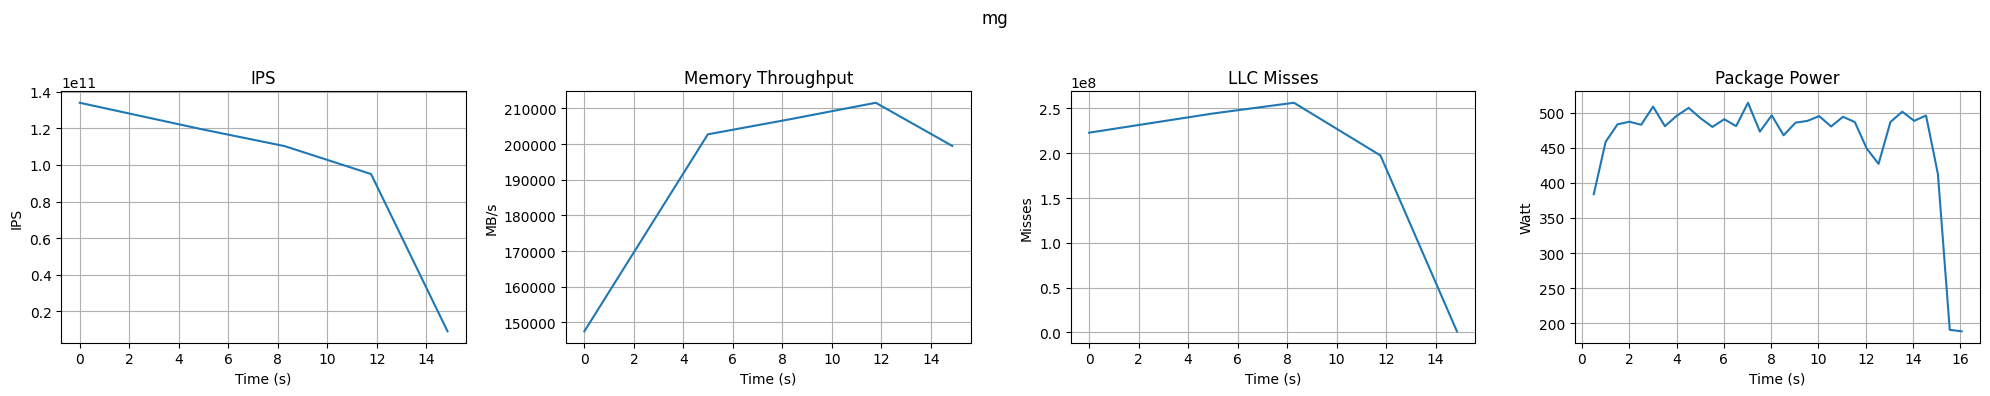

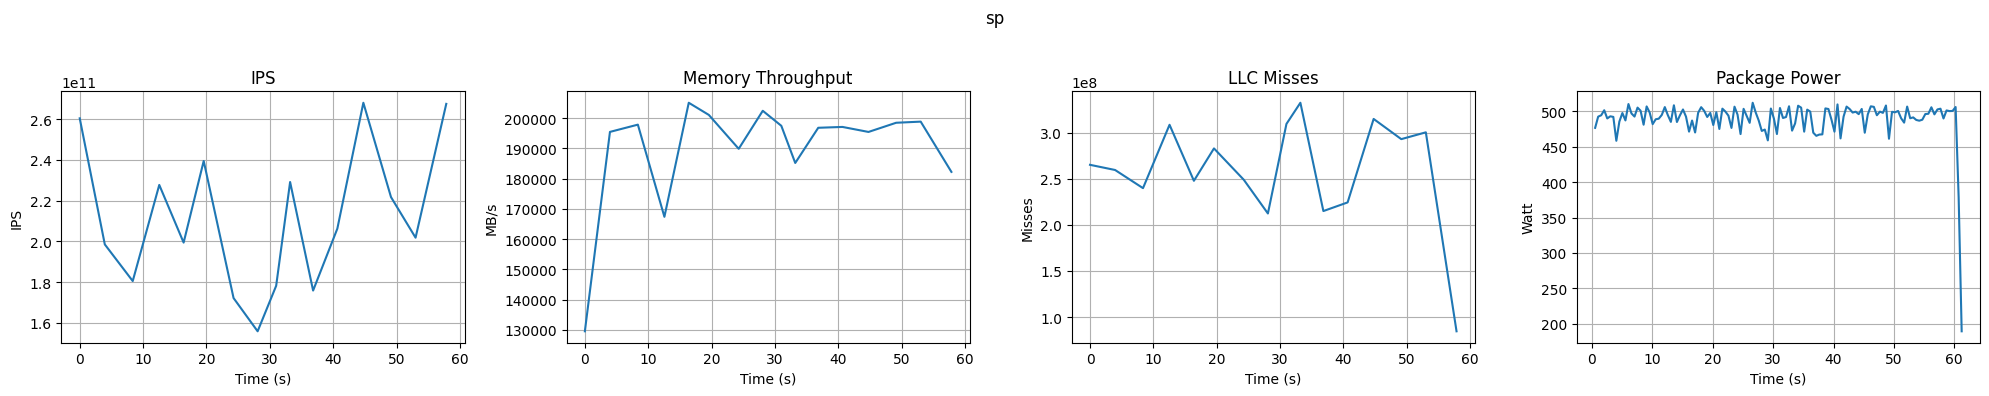

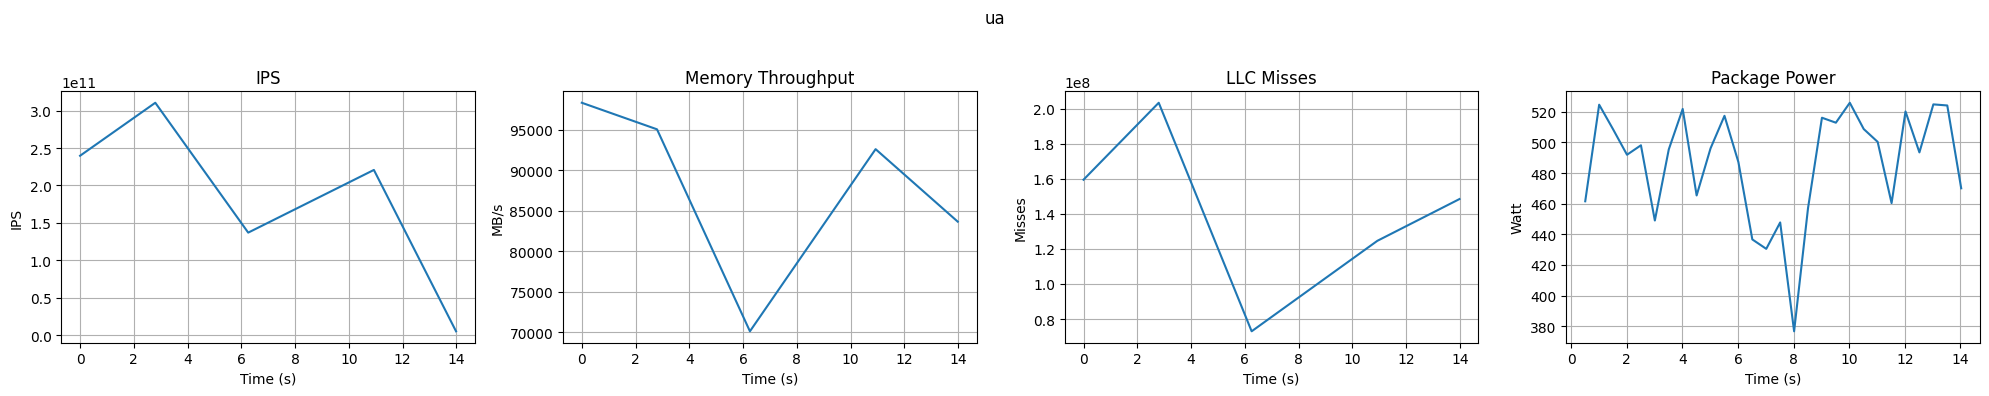

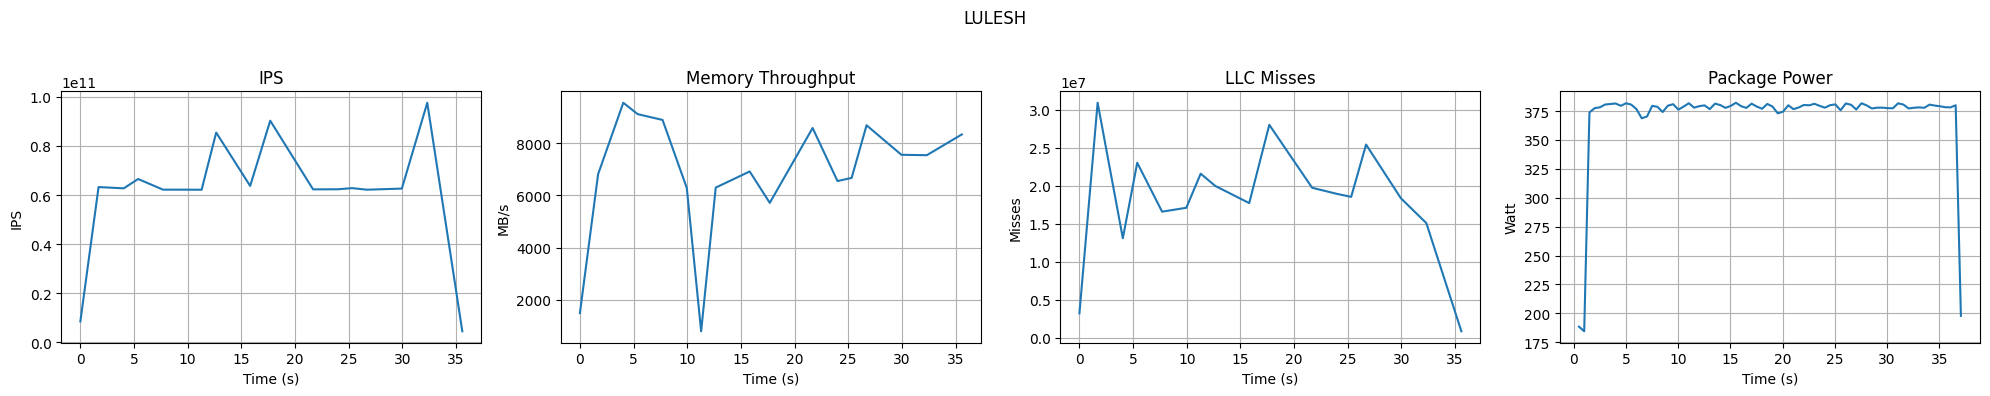

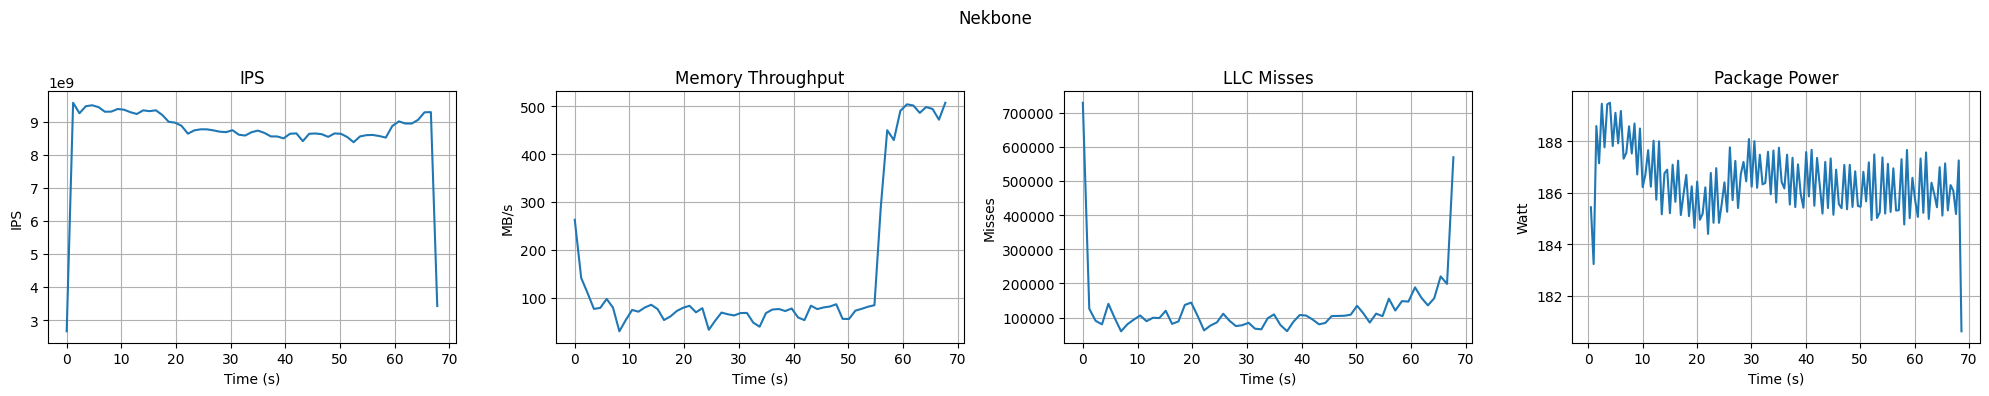

In [8]:
# benchmarks = ['bt','cg','ep','ft','is','lu','mg','sp','ua','miniFE','LULESH','Nekbone']
benchmarks = ['bt','cg','ep','ft','is','lu','mg','sp','ua','LULESH','Nekbone']
BASE = "../data/npb_solo/run1"

data = collect_data(BASE)

plot_all(data)
